In [2]:
!pip install -q ifcopenshell

In [3]:
pip install install-ifcopenshell-python==0.1.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
import ifcopenshell

In [3]:
import ifcopenshell.util.element as Element

In [4]:
file=ifcopenshell.open("20190104WestRiverSide Hospital - IFC4-Autodesk_Hospital_Metric_Architecture.ifc")

In [11]:
file.by_type("IfcSite")

[#2419880=IfcSite('2hExBg8jj4NRG6zzE$aSi4',#42,'Default',$,'',#2419879,$,$,.ELEMENT.,(42,21,30,344238),(-71,-3,-35,-194702),165811.2,$,$)]

In [8]:
file.by_type("IfcProject")

[#103=IfcProject('2hExBg8jj4NRG6zzE$aSi6',#42,'Project Number',$,$,'Hospital Project','Project Status',(#95),#90)]

In [5]:
def get_objects_data_by_class(file, class_type):
    def add_pset_attributes(psets):
        for pset_name, pset_data in psets.items():
            for property_name in pset_data.keys():
                pset_attributes.add(f'{pset_name}.{property_name}')
    
    pset_attributes = set()
    objects_data = []
    objects = file.by_type(class_type)
      
    for object in objects:
        psets = Element.get_psets(object, psets_only=True)
        add_pset_attributes(psets)
        qtos = Element.get_psets(object, qtos_only=True)
        add_pset_attributes(qtos)
        objects_data.append({
            "ExpressId": object.id(),
            "GlobalId": object.GlobalId,
            "Class": object.is_a(),
            "PredefinedType": Element.get_predefined_type(object),
            "Name": object.Name,
            "Level": Element.get_container(object).Name
            if Element.get_container(object)
            else "",
            "Type": Element.get_type(object).Name
            if Element.get_type(object)
            else "",
            "QuantitySets": qtos,
            "PropertySets": psets,
        })
    return objects_data, list(pset_attributes)


def get_attribute_value(object_data, attribute):
    if "." not in attribute:
        return object_data[attribute]
    elif "." in attribute:
        pset_name = attribute.split(".",1)[0]
        prop_name = attribute.split(".",-1)[1]
        if pset_name in object_data["PropertySets"].keys():
            if prop_name in object_data["PropertySets"][pset_name].keys():
                return object_data["PropertySets"][pset_name][prop_name]
            else:
                return None
        if pset_name in object_data["QuantitySets"].keys():
            if prop_name in object_data["QuantitySets"][pset_name].keys():
                return object_data["QuantitySets"][pset_name][prop_name]
            else:
                return None
    else:
        return None
        

data, pset_attributes = get_objects_data_by_class(file, "IfcWall")

attributes = ["ExpressId", "GlobalId", "Class", "PredefinedType", "Name", "Level", "Type"] + pset_attributes

pandas_data = []
for object_data in data:
    row = []
    for attribute in attributes:
        value = get_attribute_value(object_data, attribute)
        row.append(value)
    pandas_data.append(tuple(row))

import pandas as pd
dataframe = pd.DataFrame.from_records(pandas_data, columns=attributes)

In [6]:
for col in dataframe:
    print(dataframe[col].unique())

[  14353   29120   33191 ... 1711485 1711531 1711978]
['2HaS6zNOX8xOGjmaNi_rT3' '2HaS6zNOX8xOGjmaNi_rO2'
 '2HaS6zNOX8xOGjmaNi_rO$' ... '0qc0CA6HX7JBFypa34VD$N'
 '0qc0CA6HX7JBFypa34VD_G' '1Rhv8hlBz6uu1XIu2ztGtk']
['IfcWall' 'IfcWallStandardCase']
['NOTDEFINED']
['Basic Wall:Exterior - Limestone on Mtl. Stud w/ base and cap:186972'
 'Basic Wall:Exterior - Limestone on Mtl. Stud w/ base and cap:187165'
 'Basic Wall:Exterior - Limestone on Mtl. Stud w/ base and cap:187168' ...
 'Basic Wall:Interior - 183mm Donor Wall:952609'
 'Basic Wall:Interior - 183mm Donor Wall:952678'
 'Basic Wall:Interior - Water Wall:953825']
['Level 1' 'Level 5' 'Level 4' 'Level 3' 'Level 2' 'Level 6' 'Level 7A'
 'Level 7']
['Basic Wall:Exterior - Limestone on Mtl. Stud w/ base and cap'
 'Basic Wall:Exterior - Metal Panel on Mtl. Stud'
 'Basic Wall:Interior - 183mm Partition'
 'Basic Wall:Exterior - Metal Panel on 92 mm Mtl. Stud'
 'Basic Wall:Exterior - Brick on Mtl. Stud w/ cap'
 'Basic Wall:Exterior - Brick on M

In [8]:
dataframe.isnull().sum()

ExpressId                              0
GlobalId                               0
Class                                  0
PredefinedType                         0
Name                                   0
Level                                  0
Type                                   0
Pset_WallCommon.id                     0
BaseQuantities.GrossVolume           158
BaseQuantities.GrossSideArea         158
Pset_WallCommon.LoadBearing            0
Pset_WallCommon.Reference              0
BaseQuantities.GrossFootprintArea    158
BaseQuantities.Height                158
Pset_WallCommon.ExtendToStructure      0
BaseQuantities.Length                158
BaseQuantities.Width                 158
Pset_WallCommon.IsExternal             0
BaseQuantities.id                    158
dtype: int64

#### Removing all ID and Reference numbers. Removed ExpressId, GlobalId, Predefined Type, BaseQuantities.id,Pset_WallCommon.id, Pset_WallCommon.Reference

In [9]:
dataframe=dataframe.drop(["ExpressId","GlobalId","PredefinedType","BaseQuantities.id","Pset_WallCommon.id","Pset_WallCommon.Reference"],axis=1)

In [10]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Class                              1440 non-null   object 
 1   Name                               1440 non-null   object 
 2   Level                              1440 non-null   object 
 3   Type                               1440 non-null   object 
 4   BaseQuantities.GrossVolume         1282 non-null   float64
 5   BaseQuantities.GrossSideArea       1282 non-null   float64
 6   Pset_WallCommon.LoadBearing        1440 non-null   bool   
 7   BaseQuantities.GrossFootprintArea  1282 non-null   float64
 8   BaseQuantities.Height              1282 non-null   float64
 9   Pset_WallCommon.ExtendToStructure  1440 non-null   bool   
 10  BaseQuantities.Length              1282 non-null   float64
 11  BaseQuantities.Width               1282 non-null   float

In [11]:
wall=dataframe.loc[dataframe["Class"]=="IfcWall"]
wall_std=dataframe.loc[dataframe["Class"]=="IfcWallStandardCase"]

In [12]:
wall_std.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1282 entries, 23 to 1439
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Class                              1282 non-null   object 
 1   Name                               1282 non-null   object 
 2   Level                              1282 non-null   object 
 3   Type                               1282 non-null   object 
 4   BaseQuantities.GrossVolume         1282 non-null   float64
 5   BaseQuantities.GrossSideArea       1282 non-null   float64
 6   Pset_WallCommon.LoadBearing        1282 non-null   bool   
 7   BaseQuantities.GrossFootprintArea  1282 non-null   float64
 8   BaseQuantities.Height              1282 non-null   float64
 9   Pset_WallCommon.ExtendToStructure  1282 non-null   bool   
 10  BaseQuantities.Length              1282 non-null   float64
 11  BaseQuantities.Width               1282 non-null   floa

In [13]:
wall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158 entries, 0 to 1435
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Class                              158 non-null    object 
 1   Name                               158 non-null    object 
 2   Level                              158 non-null    object 
 3   Type                               158 non-null    object 
 4   BaseQuantities.GrossVolume         0 non-null      float64
 5   BaseQuantities.GrossSideArea       0 non-null      float64
 6   Pset_WallCommon.LoadBearing        158 non-null    bool   
 7   BaseQuantities.GrossFootprintArea  0 non-null      float64
 8   BaseQuantities.Height              0 non-null      float64
 9   Pset_WallCommon.ExtendToStructure  158 non-null    bool   
 10  BaseQuantities.Length              0 non-null      float64
 11  BaseQuantities.Width               0 non-null      float6

In [14]:
wall[['Wall_type', 'Material']] = wall["Type"].apply(lambda x: pd.Series(str(x).split("-")))

C:\Users\USER\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [15]:
wall

,Class,Name,Level,Type,BaseQuantities.GrossVolume,BaseQuantities.GrossSideArea,Pset_WallCommon.LoadBearing,BaseQuantities.GrossFootprintArea,BaseQuantities.Height,Pset_WallCommon.ExtendToStructure,BaseQuantities.Length,BaseQuantities.Width,Pset_WallCommon.IsExternal,Wall_type,Material
0,IfcWall,Basic Wall:Exterior - Limestone on Mtl. Stud w...,Level 1,Basic Wall:Exterior - Limestone on Mtl. Stud w...,NaN,NaN,False,NaN,NaN,False,NaN,NaN,True,Basic Wall:Exterior,Limestone on Mtl. Stud w/ base and cap
1,IfcWall,Basic Wall:Exterior - Limestone on Mtl. Stud w...,Level 1,Basic Wall:Exterior - Limestone on Mtl. Stud w...,NaN,NaN,False,NaN,NaN,False,NaN,NaN,True,Basic Wall:Exterior,Limestone on Mtl. Stud w/ base and cap
2,IfcWall,Basic Wall:Exterior - Limestone on Mtl. Stud w...,Level 1,Basic Wall:Exterior - Limestone on Mtl. Stud w...,NaN,NaN,False,NaN,NaN,False,NaN,NaN,True,Basic Wall:Exterior,Limestone on Mtl. Stud w/ base and cap
3,IfcWall,Basic Wall:Exterior - Limestone on Mtl. Stud w...,Level 1,Basic Wall:Exterior - Limestone on Mtl. Stud w...,NaN,NaN,False,NaN,NaN,False,NaN,NaN,True,Basic Wall:Exterior,Limestone on Mtl. Stud w/ base and cap
4,IfcWall,Basic Wall:Exterior - Limestone on Mtl. Stud w...,Level 1,Basic Wall:Exterior - Limestone on Mtl. Stud w...,NaN,NaN,False,NaN,NaN,False,NaN,NaN,True,Basic Wall:Exterior,Limestone on Mtl. Stud w/ base and cap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,IfcWall,Basic Wall:Exterior - Metal Panel on Mtl. Stud...,Level 7A,Basic Wall:Exterior - Metal Panel on Mtl. Stud,NaN,NaN,False,NaN,NaN,False,NaN,NaN,True,Basic Wall:Exterior,Metal Panel on Mtl. Stud
1405,IfcWall,Basic Wall:Exterior - Metal Panel on Mtl. Stud...,Level 6,Basic Wall:Exterior - Metal Panel on Mtl. Stud,NaN,NaN,False,NaN,NaN,False,NaN,NaN,True,Basic Wall:Exterior,Metal Panel on Mtl. Stud
1406,IfcWall,Basic Wall:Exterior - Metal Panel on Mtl. Stud...,Level 5,Basic Wall:Exterior - Metal Panel on Mtl. Stud,NaN,NaN,False,NaN,NaN,False,NaN,NaN,True,Basic Wall:Exterior,Metal Panel on Mtl. Stud
1434,IfcWall,Basic Wall:Exterior - Metal Panel on Mtl. Stud...,Level 1,Basic Wall:Exterior - Metal Panel on Mtl. Stud...,NaN,NaN,False,NaN,NaN,False,NaN,NaN,True,Basic Wall:Exterior,Metal Panel on Mtl. Stud at Front Entry


In [16]:
wall=wall.drop(["Name","Type","Class"],axis=1)
wall.rename(columns={"BaseQuantities.Length":"Length","Pset_WallCommon.LoadBearing":"Load_bearing","BaseQuantities.Height":"Height","BaseQuantities.GrossVolume":"Volume","BaseQuantities.Width":"Width","BaseQuantities.GrossFootprintArea":"Area","Pset_WallCommon.IsExternal":"External","BaseQuantities.GrossSideArea":"SideArea","BaseQuantities.GrossSideArea":"SideArea","Pset_WallCommon.ExtendToStructure":"Extend"},inplace=True)

In [17]:
wall

,Level,Volume,SideArea,Load_bearing,Area,Height,Extend,Length,Width,External,Wall_type,Material
0,Level 1,NaN,NaN,False,NaN,NaN,False,NaN,NaN,True,Basic Wall:Exterior,Limestone on Mtl. Stud w/ base and cap
1,Level 1,NaN,NaN,False,NaN,NaN,False,NaN,NaN,True,Basic Wall:Exterior,Limestone on Mtl. Stud w/ base and cap
2,Level 1,NaN,NaN,False,NaN,NaN,False,NaN,NaN,True,Basic Wall:Exterior,Limestone on Mtl. Stud w/ base and cap
3,Level 1,NaN,NaN,False,NaN,NaN,False,NaN,NaN,True,Basic Wall:Exterior,Limestone on Mtl. Stud w/ base and cap
4,Level 1,NaN,NaN,False,NaN,NaN,False,NaN,NaN,True,Basic Wall:Exterior,Limestone on Mtl. Stud w/ base and cap
...,...,...,...,...,...,...,...,...,...,...,...,...
1404,Level 7A,NaN,NaN,False,NaN,NaN,False,NaN,NaN,True,Basic Wall:Exterior,Metal Panel on Mtl. Stud
1405,Level 6,NaN,NaN,False,NaN,NaN,False,NaN,NaN,True,Basic Wall:Exterior,Metal Panel on Mtl. Stud
1406,Level 5,NaN,NaN,False,NaN,NaN,False,NaN,NaN,True,Basic Wall:Exterior,Metal Panel on Mtl. Stud
1434,Level 1,NaN,NaN,False,NaN,NaN,False,NaN,NaN,True,Basic Wall:Exterior,Metal Panel on Mtl. Stud at Front Entry


In [18]:
print(wall["Load_bearing"].unique())
print(wall["External"].unique())
print(wall["Extend"].unique())

[False]
[ True False]
[False]


### All walls that comes under the class are IfcWall are not load bearing and do not extend to structure

In [19]:
wall["External"].value_counts()

True     155
False      3
Name: External, dtype: int64

In [20]:
import category_encoders as ce
encoder= ce.OrdinalEncoder(cols=['Level'],return_df=True,
                           mapping=[{'col':'Level',
'mapping':{'None':0,'Level 1':1,'Level 2':2,'Level 3':3,'Level 4':4,'Level 5':5,'Level 6':6,'Level 7A':7}}])
wall = encoder.fit_transform(wall)

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

4    52
3    37
5    31
6    20
1    12
2     4
7     2
Name: Level, dtype: int64

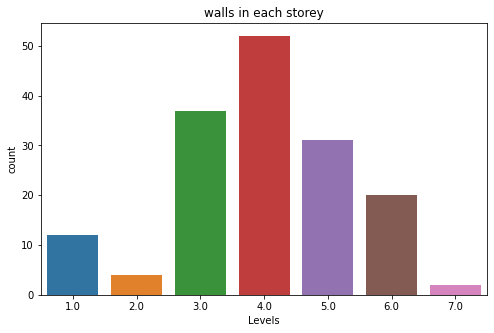

In [77]:
display(wall['Level'].value_counts().sort_values(ascending=False))
levels=[1.0,2.0,3.0,4.0,5.0,6.0,7.0]
# plot distribution of levels
plt.figure(figsize=[8, 5])

base_color = sns.color_palette()[0]
sns.countplot(data = wall, x = 'Level', order=levels)
plt.title('walls in each storey')
plt.xlabel('Levels')
plt.show()

True     11
False     1
Name: External, dtype: int64

True     3
False    1
Name: External, dtype: int64

True     36
False     1
Name: External, dtype: int64

True    52
Name: External, dtype: int64

True    31
Name: External, dtype: int64

True    20
Name: External, dtype: int64

True    2
Name: External, dtype: int64

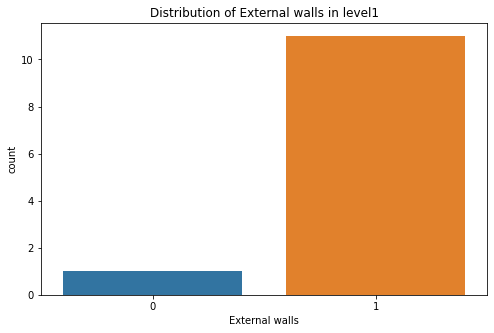

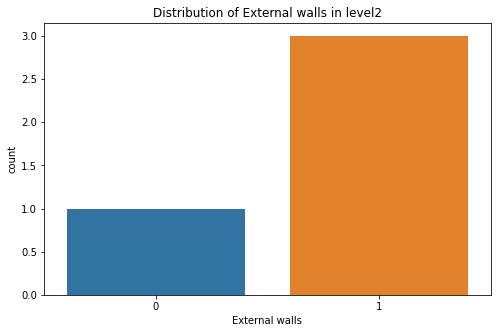

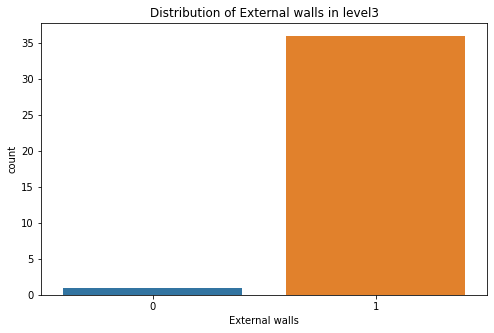

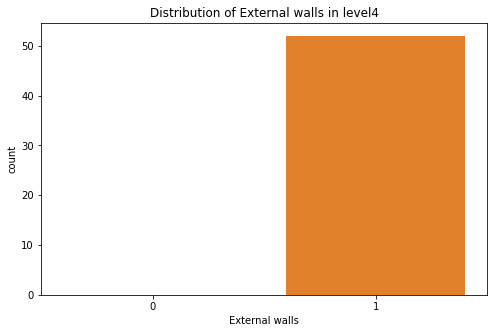

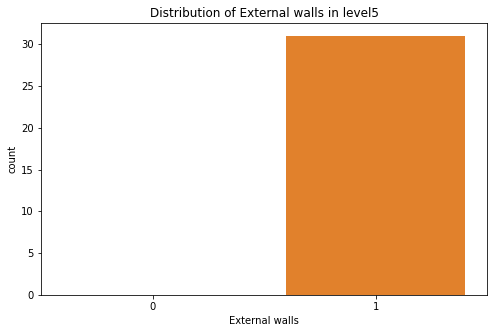

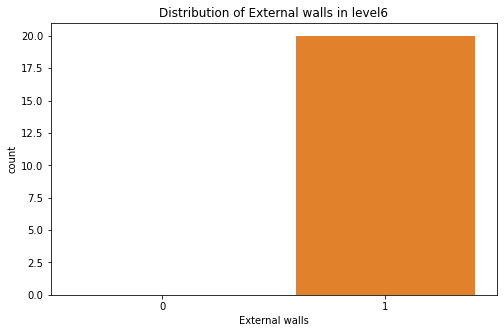

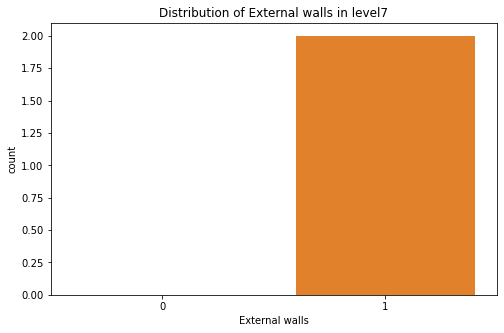

In [23]:
for i in range(1,8):
    wall_level1=wall[wall["Level"]==i]
    display(wall_level1['External'].value_counts().sort_values(ascending=False))
    # plot distribution of levels
    plt.figure(figsize=[8, 5])

    base_color = sns.color_palette()[0]
    sns.countplot(data = wall_level1, x = 'External', order=(0,1))
    plt.title('Distribution of External walls in level'+str(i))
    plt.xlabel('External walls')
        #plt.show()

In [24]:
wall["Material"].unique()

array([' Limestone on Mtl. Stud w/ base and cap',
       ' Metal Panel on Mtl. Stud', ' Metal Panel on 92 mm Mtl. Stud',
       ' 123mm Partition', ' Metal Panel on Mtl. Stud double Exterior',
       ' Metal Panel on Mtl. Stud at Front Entry'], dtype=object)

 Metal Panel on Mtl. Stud                   5
 Limestone on Mtl. Stud w/ base and cap     5
 Metal Panel on Mtl. Stud at Front Entry    1
 123mm Partition                            1
Name: Material, dtype: int64

 Metal Panel on 92 mm Mtl. Stud    3
 123mm Partition                   1
Name: Material, dtype: int64

 Metal Panel on Mtl. Stud                    27
 Metal Panel on 92 mm Mtl. Stud               8
 123mm Partition                              1
 Metal Panel on Mtl. Stud double Exterior     1
Name: Material, dtype: int64

 Metal Panel on Mtl. Stud          28
 Metal Panel on 92 mm Mtl. Stud    24
Name: Material, dtype: int64

 Metal Panel on Mtl. Stud          26
 Metal Panel on 92 mm Mtl. Stud     5
Name: Material, dtype: int64

 Metal Panel on Mtl. Stud    20
Name: Material, dtype: int64

 Metal Panel on Mtl. Stud    2
Name: Material, dtype: int64

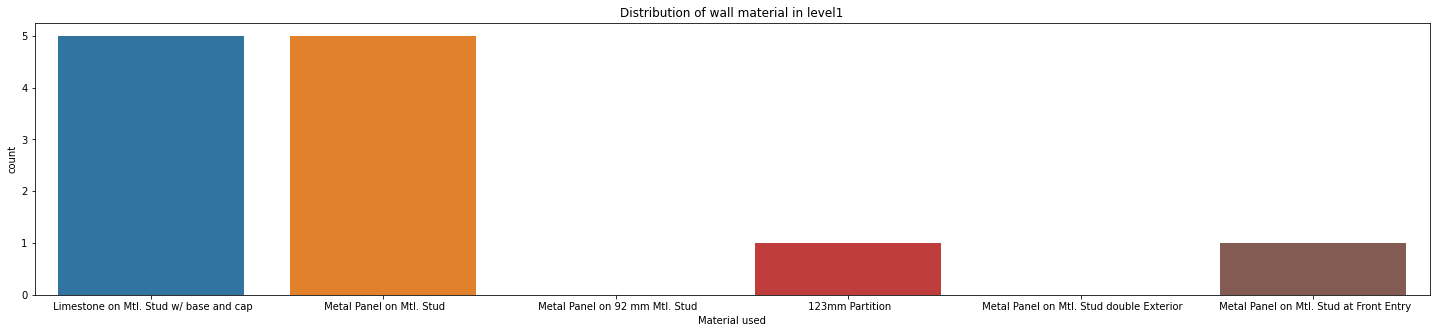

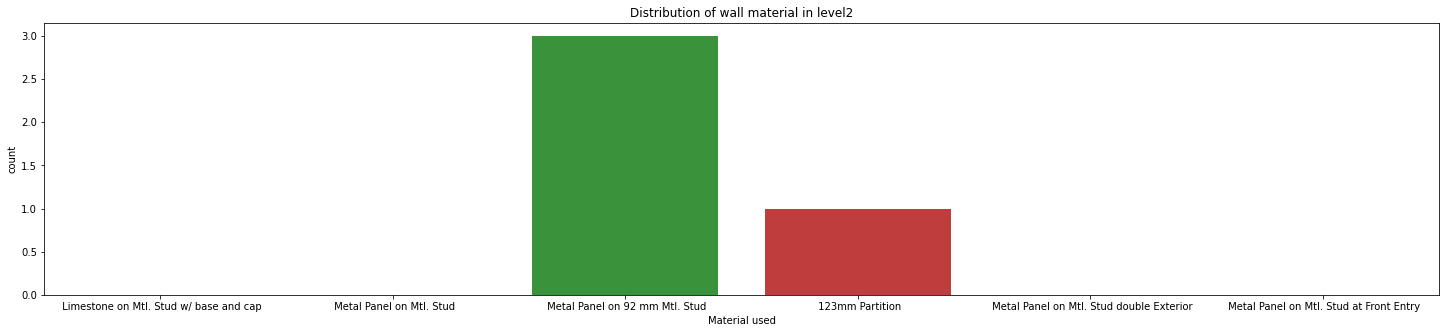

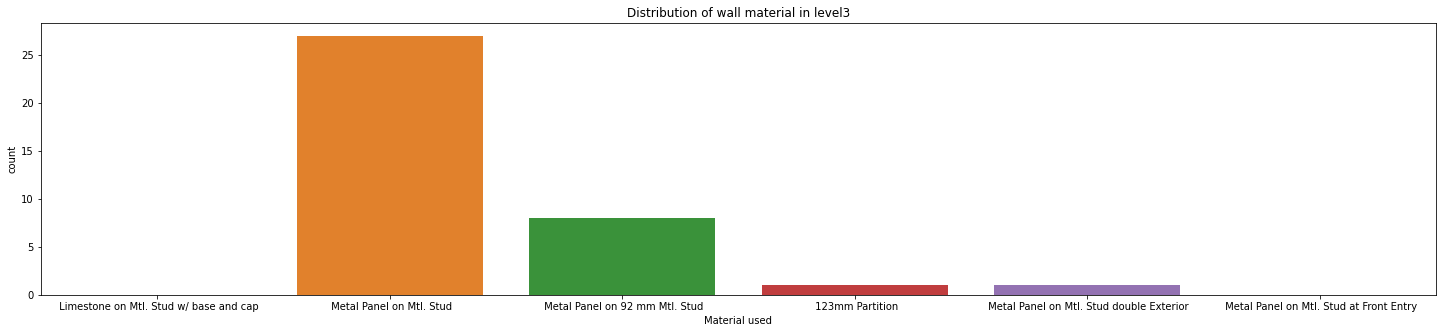

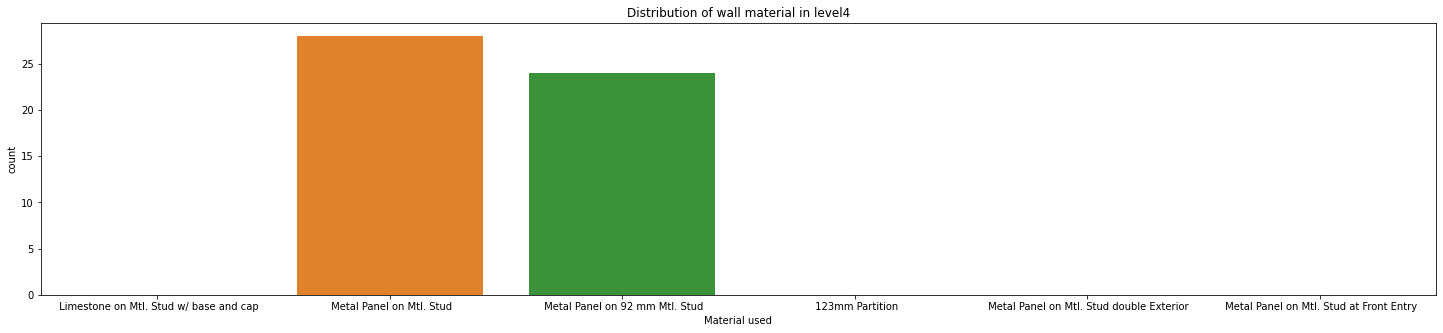

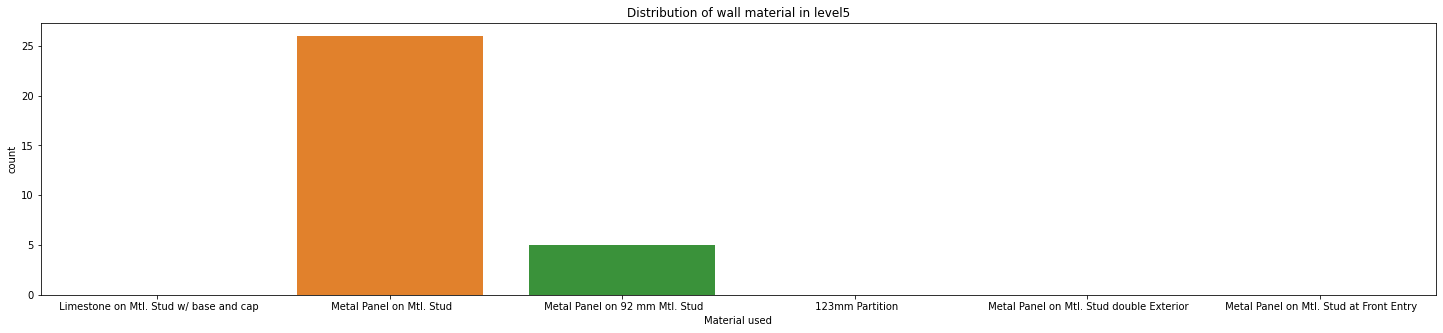

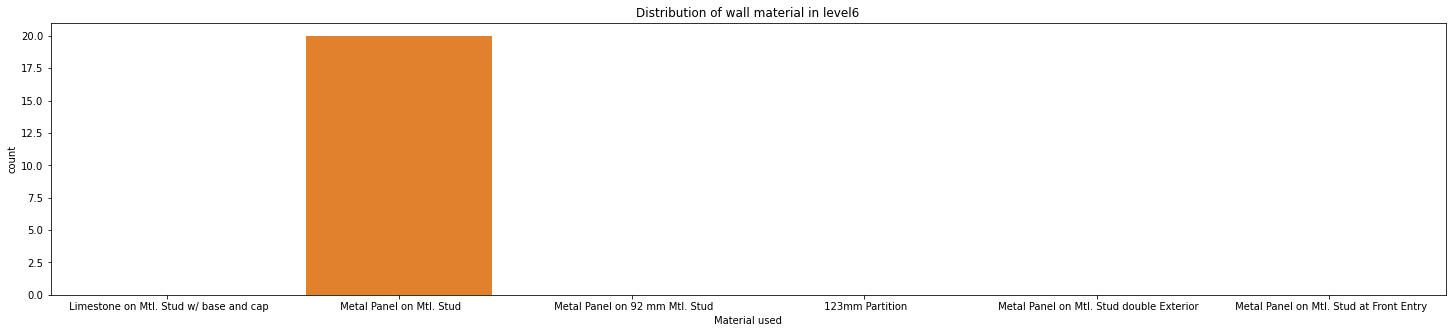

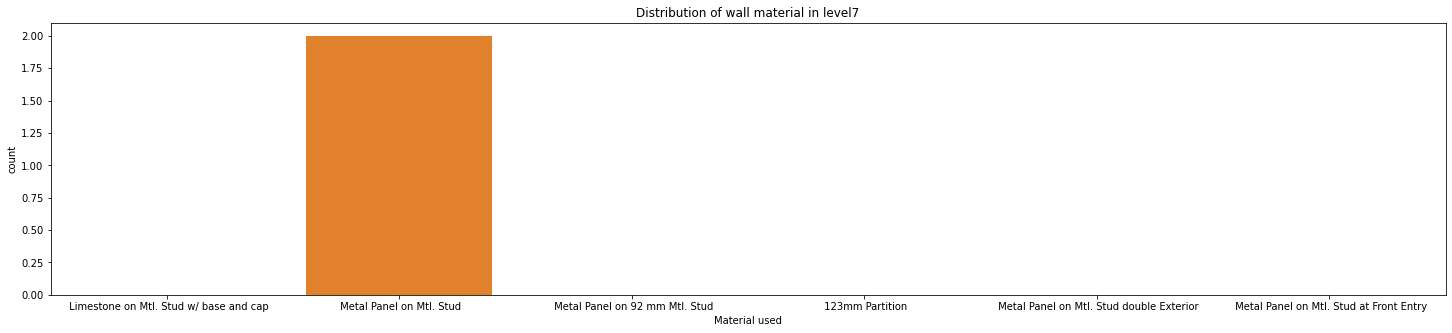

In [25]:
mat=[' Limestone on Mtl. Stud w/ base and cap',
       ' Metal Panel on Mtl. Stud', ' Metal Panel on 92 mm Mtl. Stud',
       ' 123mm Partition', ' Metal Panel on Mtl. Stud double Exterior',
       ' Metal Panel on Mtl. Stud at Front Entry']
for i in range(1,8):
        wall_level1=wall[wall["Level"]==i]
        display(wall_level1['Material'].value_counts().sort_values(ascending=False))
        plt.figure(figsize=[25, 5])

        base_color = sns.color_palette()[0]
        sns.countplot(data = wall_level1, x = 'Material', order=mat)
        plt.title('Distribution of wall material in level'+str(i))
        plt.xlabel('Material used')    

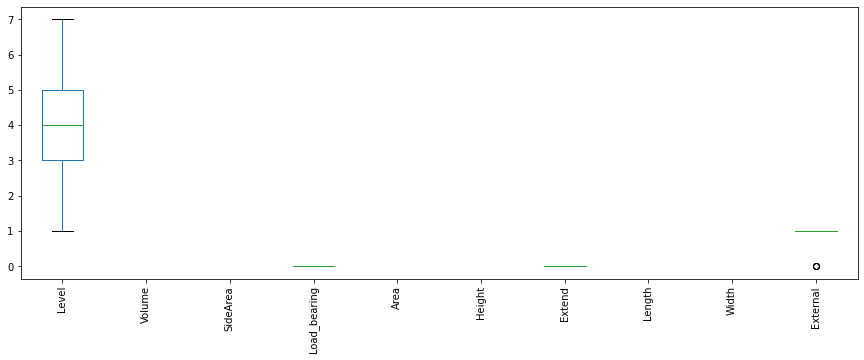

In [26]:
boxplot = wall. boxplot(figsize = (15,5), rot = 90, fontsize= '10', grid = False)

In [27]:
wall_std

,Class,Name,Level,Type,BaseQuantities.GrossVolume,BaseQuantities.GrossSideArea,Pset_WallCommon.LoadBearing,BaseQuantities.GrossFootprintArea,BaseQuantities.Height,Pset_WallCommon.ExtendToStructure,BaseQuantities.Length,BaseQuantities.Width,Pset_WallCommon.IsExternal
23,IfcWallStandardCase,Basic Wall:Exterior - Metal Panel on Mtl. Stud...,Level 3,Basic Wall:Exterior - Metal Panel on Mtl. Stud,1.265445,4.914351,False,0.498717,4500.0,False,1936.764642,257.5,True
29,IfcWallStandardCase,Basic Wall:Exterior - Metal Panel on Mtl. Stud...,Level 4,Basic Wall:Exterior - Metal Panel on Mtl. Stud,2.239591,8.697441,False,1.013717,4500.0,False,3936.764642,257.5,True
30,IfcWallStandardCase,Basic Wall:Exterior - Metal Panel on Mtl. Stud...,Level 5,Basic Wall:Exterior - Metal Panel on Mtl. Stud,4.705881,18.275267,False,1.070611,6500.0,False,4157.714108,257.5,True
33,IfcWallStandardCase,Basic Wall:Exterior - Metal Panel on Mtl. Stud...,Level 5,Basic Wall:Exterior - Metal Panel on Mtl. Stud,3.456803,13.424477,False,1.528662,4500.0,False,5936.550534,257.5,True
34,IfcWallStandardCase,Basic Wall:Exterior - Metal Panel on Mtl. Stud...,Level 4,Basic Wall:Exterior - Metal Panel on Mtl. Stud,3.350777,13.012727,False,1.505101,4500.0,False,5845.050534,257.5,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1433,IfcWallStandardCase,Basic Wall:Interior - 183mm Partition:920191,Level 5,Basic Wall:Interior - 183mm Partition,1.224819,6.693000,False,0.252540,4850.0,False,1380.000000,183.0,False
1436,IfcWallStandardCase,Basic Wall:Interior - 183mm Donor Wall:952415,Level 1,Basic Wall:Interior - 183mm Donor Wall,46.630453,200.130700,False,1.803886,25850.0,False,7742.000000,233.0,False
1437,IfcWallStandardCase,Basic Wall:Interior - 183mm Donor Wall:952609,Level 1,Basic Wall:Interior - 183mm Donor Wall,3.131986,13.442000,False,0.121160,25850.0,False,520.000000,233.0,False
1438,IfcWallStandardCase,Basic Wall:Interior - 183mm Donor Wall:952678,Level 1,Basic Wall:Interior - 183mm Donor Wall,3.131986,13.442000,False,0.121160,25850.0,False,520.000000,233.0,False


In [28]:
import category_encoders as ce
encoder= ce.OrdinalEncoder(cols=['Level'],return_df=True,
                           mapping=[{'col':'Level',
'mapping':{'Level 1':1,'Level 2':2,'Level 3':3,'Level 4':4,'Level 5':5,'Level 6':6,'Level 7':7,'Level 7A':8}}])
wall_std = encoder.fit_transform(wall_std)


In [29]:
wall_std["Pset_WallCommon.IsExternal"]=wall_std["Pset_WallCommon.IsExternal"].astype(int)
wall_std["Pset_WallCommon.ExtendToStructure"]=wall_std["Pset_WallCommon.ExtendToStructure"].astype(int)
wall_std["Pset_WallCommon.LoadBearing"]=wall_std["Pset_WallCommon.LoadBearing"].astype(int)

In [30]:
wall_std[['Wall_type_ext', 'Wall_type']] = wall_std["Type"].apply(lambda x: pd.Series(str(x).split("-")))

In [31]:
wall_std

,Class,Name,Level,Type,BaseQuantities.GrossVolume,BaseQuantities.GrossSideArea,Pset_WallCommon.LoadBearing,BaseQuantities.GrossFootprintArea,BaseQuantities.Height,Pset_WallCommon.ExtendToStructure,BaseQuantities.Length,BaseQuantities.Width,Pset_WallCommon.IsExternal,Wall_type_ext,Wall_type
23,IfcWallStandardCase,Basic Wall:Exterior - Metal Panel on Mtl. Stud...,3,Basic Wall:Exterior - Metal Panel on Mtl. Stud,1.265445,4.914351,0,0.498717,4500.0,0,1936.764642,257.5,1,Basic Wall:Exterior,Metal Panel on Mtl. Stud
29,IfcWallStandardCase,Basic Wall:Exterior - Metal Panel on Mtl. Stud...,4,Basic Wall:Exterior - Metal Panel on Mtl. Stud,2.239591,8.697441,0,1.013717,4500.0,0,3936.764642,257.5,1,Basic Wall:Exterior,Metal Panel on Mtl. Stud
30,IfcWallStandardCase,Basic Wall:Exterior - Metal Panel on Mtl. Stud...,5,Basic Wall:Exterior - Metal Panel on Mtl. Stud,4.705881,18.275267,0,1.070611,6500.0,0,4157.714108,257.5,1,Basic Wall:Exterior,Metal Panel on Mtl. Stud
33,IfcWallStandardCase,Basic Wall:Exterior - Metal Panel on Mtl. Stud...,5,Basic Wall:Exterior - Metal Panel on Mtl. Stud,3.456803,13.424477,0,1.528662,4500.0,0,5936.550534,257.5,1,Basic Wall:Exterior,Metal Panel on Mtl. Stud
34,IfcWallStandardCase,Basic Wall:Exterior - Metal Panel on Mtl. Stud...,4,Basic Wall:Exterior - Metal Panel on Mtl. Stud,3.350777,13.012727,0,1.505101,4500.0,0,5845.050534,257.5,1,Basic Wall:Exterior,Metal Panel on Mtl. Stud
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1433,IfcWallStandardCase,Basic Wall:Interior - 183mm Partition:920191,5,Basic Wall:Interior - 183mm Partition,1.224819,6.693000,0,0.252540,4850.0,0,1380.000000,183.0,0,Basic Wall:Interior,183mm Partition
1436,IfcWallStandardCase,Basic Wall:Interior - 183mm Donor Wall:952415,1,Basic Wall:Interior - 183mm Donor Wall,46.630453,200.130700,0,1.803886,25850.0,0,7742.000000,233.0,0,Basic Wall:Interior,183mm Donor Wall
1437,IfcWallStandardCase,Basic Wall:Interior - 183mm Donor Wall:952609,1,Basic Wall:Interior - 183mm Donor Wall,3.131986,13.442000,0,0.121160,25850.0,0,520.000000,233.0,0,Basic Wall:Interior,183mm Donor Wall
1438,IfcWallStandardCase,Basic Wall:Interior - 183mm Donor Wall:952678,1,Basic Wall:Interior - 183mm Donor Wall,3.131986,13.442000,0,0.121160,25850.0,0,520.000000,233.0,0,Basic Wall:Interior,183mm Donor Wall


In [32]:
wall_std=wall_std.drop(["Class","Name","Type","Wall_type_ext"],axis=1)

In [33]:
wall_std=wall_std.rename(columns={"BaseQuantities.GrossFootprintArea":"FootPrintArea","BaseQuantities.Height":"Height","Pset_WallCommon.IsExternal":"External","Pset_WallCommon.ExtendToStructure":"Extend","BaseQuantities.Length":"Length","BaseQuantities.GrossSideArea":"SideArea","BaseQuantities.GrossVolume":"Volume","BaseQuantities.Width":"Width","Pset_WallCommon.LoadBearing":"LoadBearing"})

In [34]:
wall_std["Wall_type"].unique()

array([' Metal Panel on Mtl. Stud', ' 183mm Partition',
       ' Metal Panel on 92 mm Mtl. Stud', ' Brick on Mtl. Stud w/ cap',
       ' Brick on Mtl. Stud', ' 123mm Partition', ' Blockwork 190',
       ' Blockwork 140', ' 183mm Donor Wall', ' Water Wall'], dtype=object)

In [35]:
wall_std.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1282 entries, 23 to 1439
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Level          1282 non-null   int32  
 1   Volume         1282 non-null   float64
 2   SideArea       1282 non-null   float64
 3   LoadBearing    1282 non-null   int32  
 4   FootPrintArea  1282 non-null   float64
 5   Height         1282 non-null   float64
 6   Extend         1282 non-null   int32  
 7   Length         1282 non-null   float64
 8   Width          1282 non-null   float64
 9   External       1282 non-null   int32  
 10  Wall_type      1282 non-null   object 
dtypes: float64(6), int32(4), object(1)
memory usage: 100.2+ KB


<AxesSubplot:xlabel='Wall_type', ylabel='Volume'>

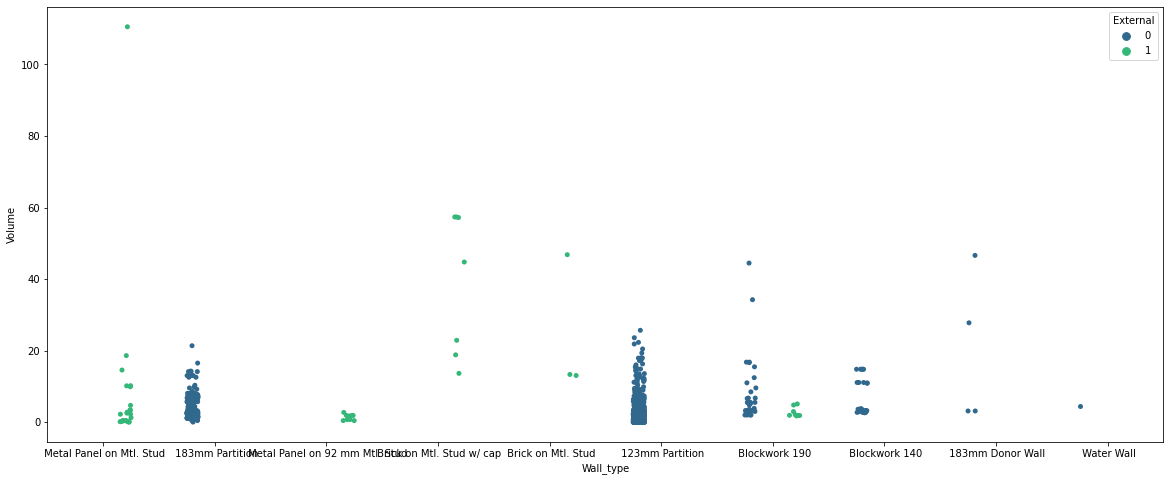

In [71]:
plt.figure(figsize=(20,8))
sns.stripplot(
    data=wall_std, x="Wall_type", y="Volume", hue="External",
    dodge=True, palette='viridis'
)

In [36]:
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

In [37]:
X = wall_std.drop(["Wall_type"],axis=1)
y = wall_std["Wall_type"]

In [38]:
clf = DecisionTreeClassifier(random_state=1234)
model = clf.fit(X, y)

[Text(125.55000000000001, 201.90857142857143, 'X[8] <= 140.75\ngini = 0.535\nsamples = 1282\nvalue = [788, 4, 373, 30, 43, 3, 7, 9, 24, 1]'),
 Text(55.800000000000004, 170.84571428571428, 'X[5] <= 16825.0\ngini = 0.003\nsamples = 789\nvalue = [788, 0, 0, 0, 0, 0, 0, 0, 0, 1]'),
 Text(27.900000000000002, 139.78285714285715, 'gini = 0.0\nsamples = 788\nvalue = [788, 0, 0, 0, 0, 0, 0, 0, 0, 0]'),
 Text(83.7, 139.78285714285715, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]'),
 Text(195.3, 170.84571428571428, 'X[8] <= 186.5\ngini = 0.413\nsamples = 493\nvalue = [0, 4, 373, 30, 43, 3, 7, 9, 24, 0]'),
 Text(139.5, 139.78285714285715, 'X[8] <= 173.5\ngini = 0.175\nsamples = 412\nvalue = [0, 0, 373, 30, 0, 0, 0, 9, 0, 0]'),
 Text(111.60000000000001, 108.72, 'X[5] <= 2850.0\ngini = 0.355\nsamples = 39\nvalue = [0, 0, 0, 30, 0, 0, 0, 9, 0, 0]'),
 Text(83.7, 77.65714285714284, 'gini = 0.0\nsamples = 9\nvalue = [0, 0, 0, 0, 0, 0, 0, 9, 0, 0]'),
 Text(139.5, 77.65714285714284, 'g

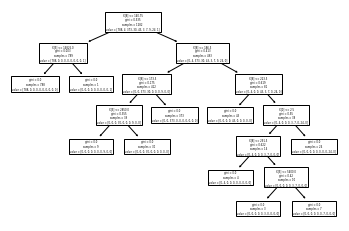

In [39]:
tree.plot_tree(clf)

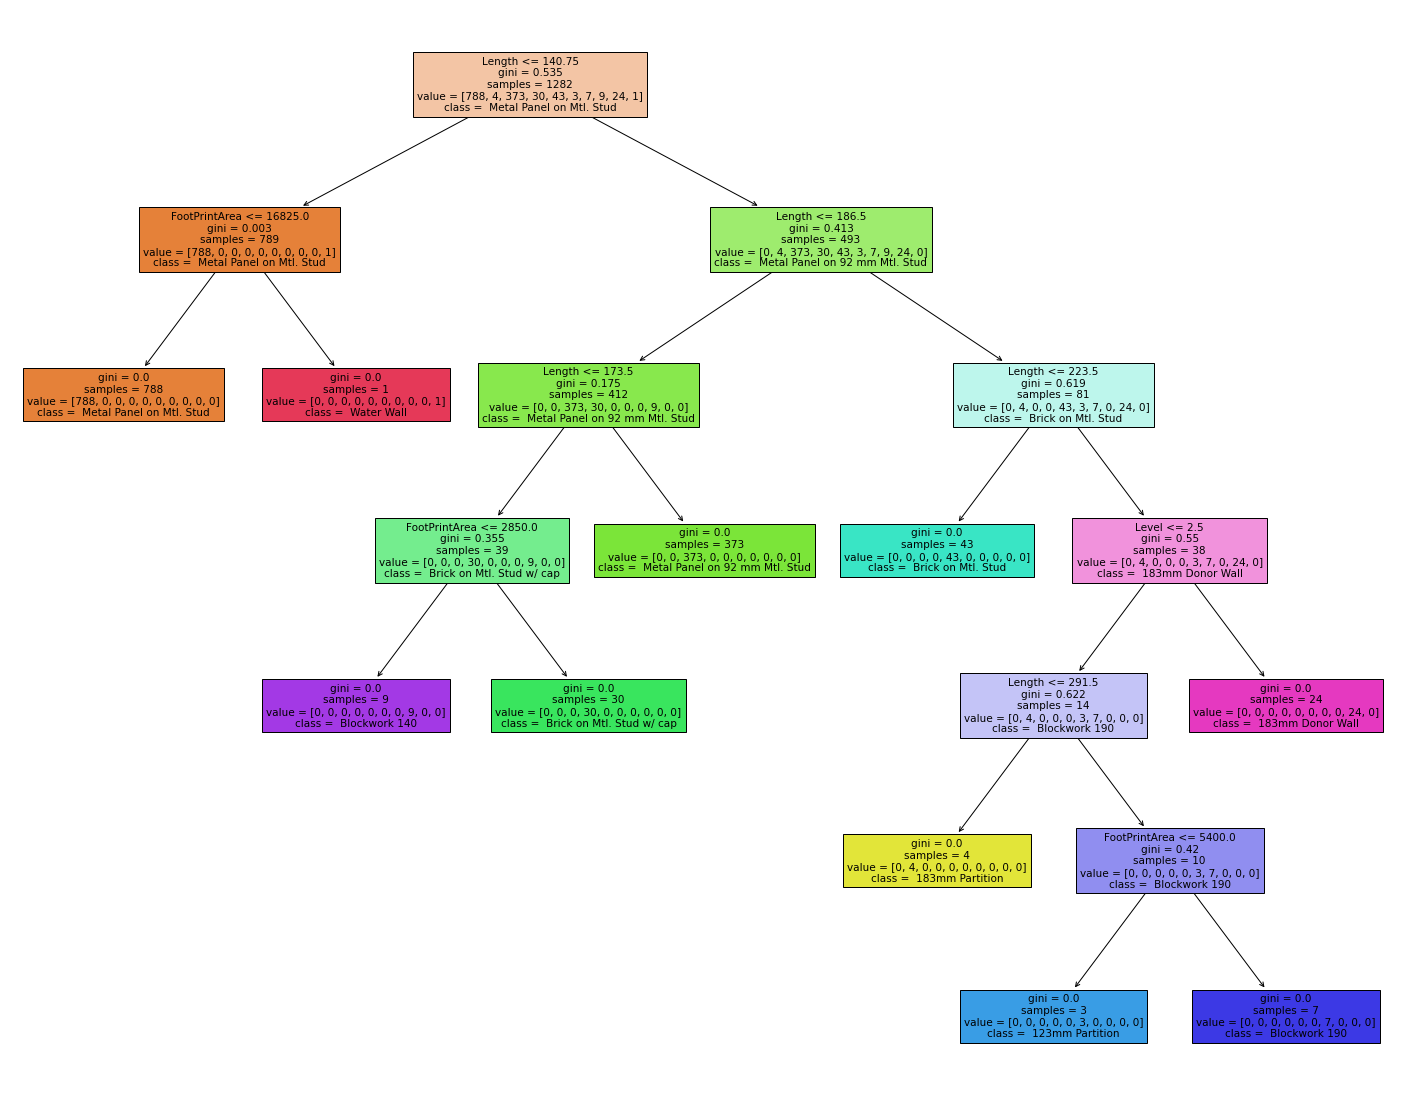

In [40]:
features=["Level","External","Volume","LoadBearing","Height","FootPrintArea","Extend","Width","Length","SideArea"]
target=[' Metal Panel on Mtl. Stud', ' 183mm Partition',
       ' Metal Panel on 92 mm Mtl. Stud', ' Brick on Mtl. Stud w/ cap',
       ' Brick on Mtl. Stud', ' 123mm Partition', ' Blockwork 190',
       ' Blockwork 140', ' 183mm Donor Wall', ' Water Wall']

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=features,  
                   class_names=target,
                   filled=True)

In [41]:
wall_std1 = pd.get_dummies(wall_std, columns = ["Wall_type"])

In [42]:
wall_std1

,Level,Volume,SideArea,LoadBearing,FootPrintArea,Height,Extend,Length,Width,External,Wall_type_ 123mm Partition,Wall_type_ 183mm Donor Wall,Wall_type_ 183mm Partition,Wall_type_ Blockwork 140,Wall_type_ Blockwork 190,Wall_type_ Brick on Mtl. Stud,Wall_type_ Brick on Mtl. Stud w/ cap,Wall_type_ Metal Panel on 92 mm Mtl. Stud,Wall_type_ Metal Panel on Mtl. Stud,Wall_type_ Water Wall
23,3,1.265445,4.914351,0,0.498717,4500.0,0,1936.764642,257.5,1,0,0,0,0,0,0,0,0,1,0
29,4,2.239591,8.697441,0,1.013717,4500.0,0,3936.764642,257.5,1,0,0,0,0,0,0,0,0,1,0
30,5,4.705881,18.275267,0,1.070611,6500.0,0,4157.714108,257.5,1,0,0,0,0,0,0,0,0,1,0
33,5,3.456803,13.424477,0,1.528662,4500.0,0,5936.550534,257.5,1,0,0,0,0,0,0,0,0,1,0
34,4,3.350777,13.012727,0,1.505101,4500.0,0,5845.050534,257.5,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1433,5,1.224819,6.693000,0,0.252540,4850.0,0,1380.000000,183.0,0,0,0,1,0,0,0,0,0,0,0
1436,1,46.630453,200.130700,0,1.803886,25850.0,0,7742.000000,233.0,0,0,1,0,0,0,0,0,0,0,0
1437,1,3.131986,13.442000,0,0.121160,25850.0,0,520.000000,233.0,0,0,1,0,0,0,0,0,0,0,0
1438,1,3.131986,13.442000,0,0.121160,25850.0,0,520.000000,233.0,0,0,1,0,0,0,0,0,0,0,0


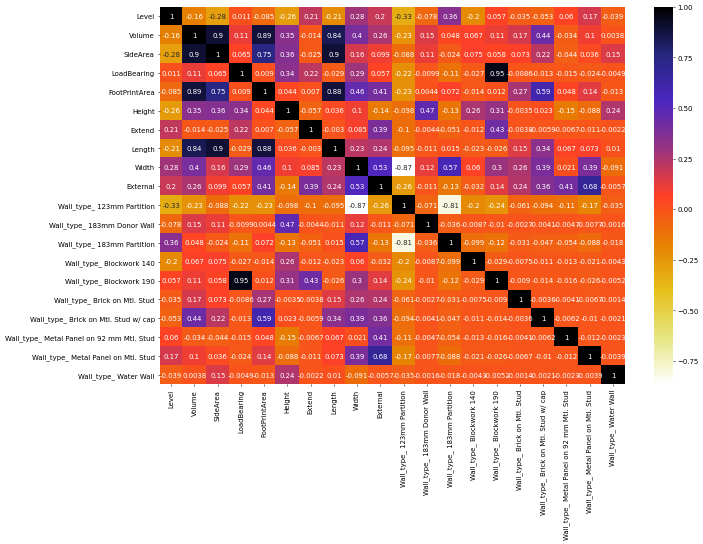

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns 
plt.figure(figsize=(15,10),dpi=50)
cor=wall_std1.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.CMRmap_r)
plt.show()

### Majority of Block work 190 walls have load bearing capacity

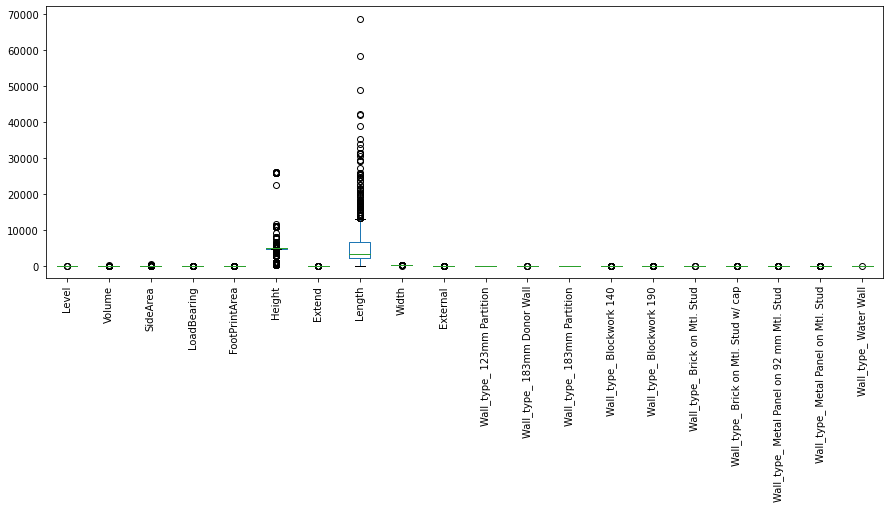

In [44]:
boxplot = wall_std1. boxplot(figsize = (15,5), rot = 90, fontsize= '10', grid = False)

In [45]:
def get_objects_data_by_class(file, class_type):
    def add_pset_attributes(psets):
        for pset_name, pset_data in psets.items():
            for property_name in pset_data.keys():
                pset_attributes.add(f'{pset_name}.{property_name}')
    
    pset_attributes = set()
    objects_data = []
    objects = file.by_type(class_type)
      
    for object in objects:
        psets = Element.get_psets(object, psets_only=True)
        add_pset_attributes(psets)
        qtos = Element.get_psets(object, qtos_only=True)
        add_pset_attributes(qtos)
        objects_data.append({
            "ExpressId": object.id(),
            "GlobalId": object.GlobalId,
            "Class": object.is_a(),
            "PredefinedType": Element.get_predefined_type(object),
            "Name": object.Name,
            "Level": Element.get_container(object).Name
            if Element.get_container(object)
            else "",
            "Type": Element.get_type(object).Name
            if Element.get_type(object)
            else "",
            "QuantitySets": qtos,
            "PropertySets": psets,
        })
    return objects_data, list(pset_attributes)


def get_attribute_value(object_data, attribute):
    if "." not in attribute:
        return object_data[attribute]
    elif "." in attribute:
        pset_name = attribute.split(".",1)[0]
        prop_name = attribute.split(".",-1)[1]
        if pset_name in object_data["PropertySets"].keys():
            if prop_name in object_data["PropertySets"][pset_name].keys():
                return object_data["PropertySets"][pset_name][prop_name]
            else:
                return None
        if pset_name in object_data["QuantitySets"].keys():
            if prop_name in object_data["QuantitySets"][pset_name].keys():
                return object_data["QuantitySets"][pset_name][prop_name]
            else:
                return None
    else:
        return None
        

data, pset_attributes = get_objects_data_by_class(file, "IfcRoof")

attributes = ["ExpressId", "GlobalId", "Class", "PredefinedType", "Name", "Level", "Type"] + pset_attributes

pandas_data = []
for object_data in data:
    row = []
    for attribute in attributes:
        value = get_attribute_value(object_data, attribute)
        row.append(value)
    pandas_data.append(tuple(row))

import pandas as pd
roof = pd.DataFrame.from_records(pandas_data, columns=attributes)

In [46]:
roof

,ExpressId,GlobalId,Class,PredefinedType,Name,Level,Type,Pset_RoofCommon.ProjectedArea,Pset_RoofCommon.IsExternal,Pset_RoofCommon.Reference,Pset_RoofCommon.id,Pset_RoofCommon.TotalArea
0,1228823,2wV7MXoU9CUuWvtM7XEk_5,IfcRoof,NOTDEFINED,Basic Roof:Grass Roof:792788,Level 3,,240.901882,True,Basic Roof:Grass Roof,1228995,240.907303
1,1229025,2wV7MXoU9CUuWvtM7XEkwk,IfcRoof,NOTDEFINED,Basic Roof:Paver Roof:793087,Level 3,,474.040965,True,Basic Roof:Paver Roof,1229326,301.635737
2,1229354,2wV7MXoU9CUuWvtM7XEktR,IfcRoof,NOTDEFINED,Basic Roof:Grass Roof:793226,Level 3,,90.445317,True,Basic Roof:Grass Roof,1229456,90.444171
3,1229483,2wV7MXoU9CUuWvtM7XEktm,IfcRoof,NOTDEFINED,Basic Roof:Grass Roof:793249,Level 3,,81.961671,True,Basic Roof:Grass Roof,1229585,81.959203
4,1276832,1OV06Y3c5D8vODNypVnS6v,IfcRoof,NOTDEFINED,Basic Roof:Paver Roof:801370,Level 3,,307.251952,True,Basic Roof:Paver Roof,1277152,221.584015
5,1277179,1OV06Y3c5D8vODNypVnSVI,IfcRoof,NOTDEFINED,Basic Roof:Grass Roof:801841,Level 3,,188.241705,True,Basic Roof:Grass Roof,1277362,188.241620
6,1277389,1OV06Y3c5D8vODNypVnSSX,IfcRoof,NOTDEFINED,Basic Roof:Grass Roof:801986,Level 3,,52.289228,True,Basic Roof:Grass Roof,1277491,52.286863
7,1277518,1OV06Y3c5D8vODNypVnSSG,IfcRoof,NOTDEFINED,Basic Roof:Grass Roof:802035,Level 3,,33.380269,True,Basic Roof:Grass Roof,1277620,33.377688
8,1278705,0yhpHAyTP1lfDR_smbPjNk,IfcRoof,NOTDEFINED,Basic Roof:Paver Roof:805886,Level 3,,381.427108,True,Basic Roof:Paver Roof,1279075,292.862953
9,1279102,0yhpHAyTP1lfDR_smbPjBl,IfcRoof,NOTDEFINED,Basic Roof:Paver Roof:806143,Level 3,,277.077178,True,Basic Roof:Paver Roof,1279436,189.408934


In [47]:
roof["Pset_RoofCommon.Reference"].unique()

array(['Basic Roof:Grass Roof', 'Basic Roof:Paver Roof',
       'Basic Roof:Ballasted', 'Basic Roof:Cold Roof - Concrete'],
      dtype=object)

Basic Roof:Grass Roof              16
Basic Roof:Paver Roof               5
Basic Roof:Cold Roof - Concrete     2
Basic Roof:Ballasted                1
Name: Pset_RoofCommon.Reference, dtype: int64

Text(0.5, 0, 'Roof type')

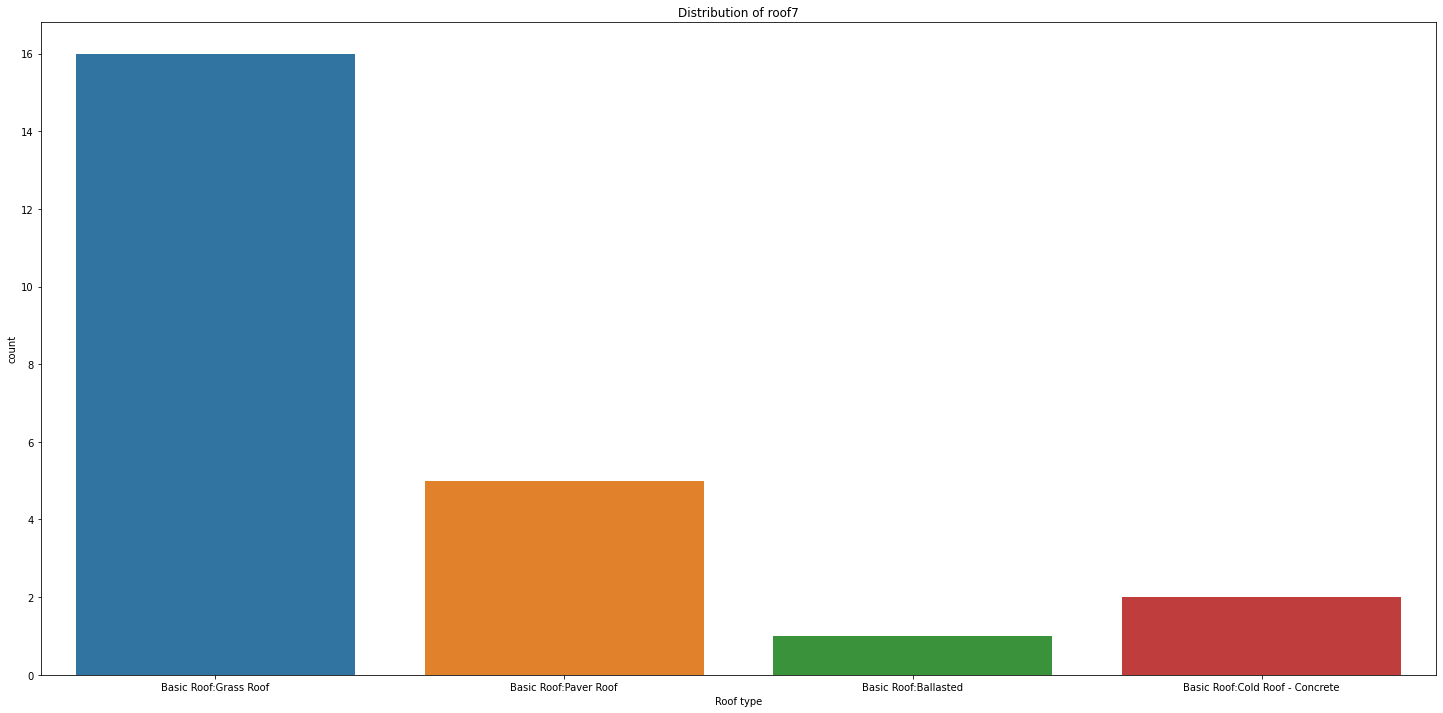

In [48]:
mat=['Basic Roof:Grass Roof', 'Basic Roof:Paver Roof',
       'Basic Roof:Ballasted', 'Basic Roof:Cold Roof - Concrete']
display(roof['Pset_RoofCommon.Reference'].value_counts().sort_values(ascending=False))
plt.figure(figsize=[25, 12])
base_color = sns.color_palette()[0]
sns.countplot(data = roof, x = 'Pset_RoofCommon.Reference', order=mat)
plt.title('Distribution of roof'+str(i))
plt.xlabel('Roof type')    

In [49]:
import category_encoders as ce
encoder= ce.OrdinalEncoder(cols=['Level'],return_df=True,
                           mapping=[{'col':'Level',
'mapping':{'Level 1':1,'Level 2':2,'Level 3':3,'Level 4':4,'Level 5':5,'Level 6':6,'Level 7':7,'Level 7A':8}}])
roof= encoder.fit_transform(roof)

In [50]:
mat=['Basic Roof:Grass Roof', 'Basic Roof:Paver Roof',
       'Basic Roof:Ballasted', 'Basic Roof:Cold Roof - Concrete']
for i in mat:
        wall_level1=roof[roof["Pset_RoofCommon.Reference"]==i]
        print(i)
        display(wall_level1['Pset_RoofCommon.TotalArea'].sum())

Basic Roof:Grass Roof


1721.1258747347033

Basic Roof:Paver Roof


1226.203964443276

Basic Roof:Ballasted


143.679175053975

Basic Roof:Cold Roof - Concrete


54.90441240482011

In [51]:
roof=roof.drop(["ExpressId","GlobalId","Class","PredefinedType","Name","Pset_RoofCommon.id","Type"],axis=1)

In [52]:
roof=roof.rename(columns={"Pset_RoofCommon.Reference":"Type","Pset_RoofCommon.TotalArea":"Area","Pset_RoofCommon.IsExternal":"External","Pset_RoofCommon.ProjectedArea":"Projected_area"})

In [53]:
roof

,Level,Projected_area,External,Type,Area
0,3,240.901882,True,Basic Roof:Grass Roof,240.907303
1,3,474.040965,True,Basic Roof:Paver Roof,301.635737
2,3,90.445317,True,Basic Roof:Grass Roof,90.444171
3,3,81.961671,True,Basic Roof:Grass Roof,81.959203
4,3,307.251952,True,Basic Roof:Paver Roof,221.584015
5,3,188.241705,True,Basic Roof:Grass Roof,188.241620
6,3,52.289228,True,Basic Roof:Grass Roof,52.286863
7,3,33.380269,True,Basic Roof:Grass Roof,33.377688
8,3,381.427108,True,Basic Roof:Paver Roof,292.862953
9,3,277.077178,True,Basic Roof:Paver Roof,189.408934


In [54]:
roof["External"]=roof["External"].astype(int)

In [55]:
roof

,Level,Projected_area,External,Type,Area
0,3,240.901882,1,Basic Roof:Grass Roof,240.907303
1,3,474.040965,1,Basic Roof:Paver Roof,301.635737
2,3,90.445317,1,Basic Roof:Grass Roof,90.444171
3,3,81.961671,1,Basic Roof:Grass Roof,81.959203
4,3,307.251952,1,Basic Roof:Paver Roof,221.584015
5,3,188.241705,1,Basic Roof:Grass Roof,188.241620
6,3,52.289228,1,Basic Roof:Grass Roof,52.286863
7,3,33.380269,1,Basic Roof:Grass Roof,33.377688
8,3,381.427108,1,Basic Roof:Paver Roof,292.862953
9,3,277.077178,1,Basic Roof:Paver Roof,189.408934


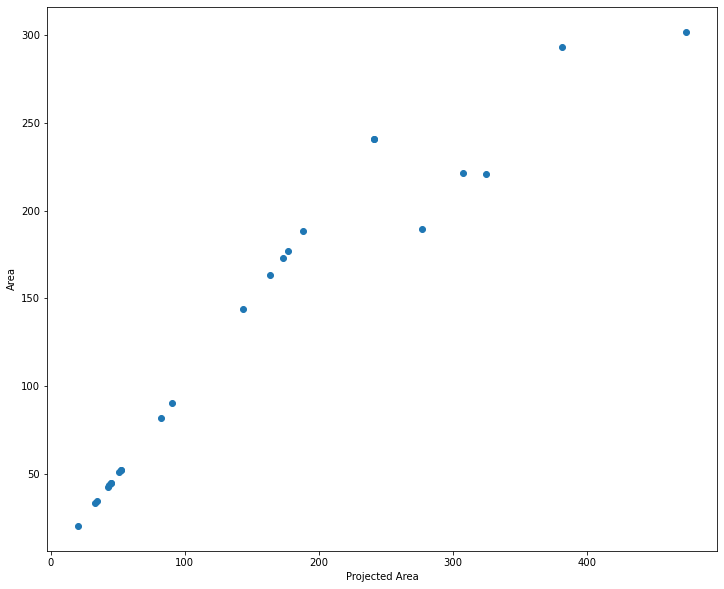

In [56]:
plt.figure(figsize=(12, 10))
plt.scatter(roof["Projected_area"], roof["Area"])
plt.xlabel("Projected Area")
plt.ylabel("Area")
plt.show()

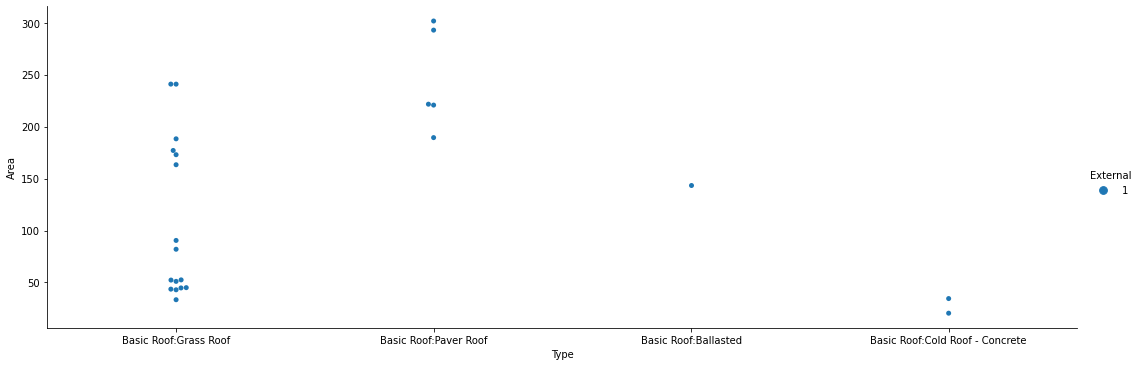

In [65]:
sns.catplot(
    data=roof, x="Type", y="Area", hue="External",
    kind="swarm", aspect=3
)

In [86]:
def get_objects_data_by_class(file, class_type):
    def add_pset_attributes(psets):
        for pset_name, pset_data in psets.items():
            for property_name in pset_data.keys():
                pset_attributes.add(f'{pset_name}.{property_name}')
    
    pset_attributes = set()
    objects_data = []
    objects = file.by_type(class_type)
      
    for object in objects:
        psets = Element.get_psets(object, psets_only=True)
        add_pset_attributes(psets)
        qtos = Element.get_psets(object, qtos_only=True)
        add_pset_attributes(qtos)
        objects_data.append({
            "ExpressId": object.id(),
            "GlobalId": object.GlobalId,
            "Class": object.is_a(),
            "PredefinedType": Element.get_predefined_type(object),
            "Name": object.Name,
            "Level": Element.get_container(object).Name
            if Element.get_container(object)
            else "",
            "Type": Element.get_type(object).Name
            if Element.get_type(object)
            else "",
            "QuantitySets": qtos,
            "PropertySets": psets,
        })
    return objects_data, list(pset_attributes)


def get_attribute_value(object_data, attribute):
    if "." not in attribute:
        return object_data[attribute]
    elif "." in attribute:
        pset_name = attribute.split(".",1)[0]
        prop_name = attribute.split(".",-1)[1]
        if pset_name in object_data["PropertySets"].keys():
            if prop_name in object_data["PropertySets"][pset_name].keys():
                return object_data["PropertySets"][pset_name][prop_name]
            else:
                return None
        if pset_name in object_data["QuantitySets"].keys():
            if prop_name in object_data["QuantitySets"][pset_name].keys():
                return object_data["QuantitySets"][pset_name][prop_name]
            else:
                return None
    else:
        return None
        

data, pset_attributes = get_objects_data_by_class(file, "IfcCovering")

attributes = ["ExpressId", "GlobalId", "Class", "PredefinedType", "Name", "Level", "Type"] + pset_attributes

pandas_data = []
for object_data in data:
    row = []
    for attribute in attributes:
        value = get_attribute_value(object_data, attribute)
        row.append(value)
    pandas_data.append(tuple(row))

import pandas as pd
be = pd.DataFrame.from_records(pandas_data, columns=attributes)

In [93]:
be

,ExpressId,GlobalId,Class,PredefinedType,Name,Level,Type,Pset_CoveringCommon.id,BaseQuantities.GrossCeilingArea,Pset_CoveringCommon.Reference,Pset_CoveringCommon.IsExternal,Pset_CoveringCommon.Finish,BaseQuantities.id
0,49029,0GzGTQ5S5Agwd6OgNQWJD7,IfcCovering,CEILING,Roof Soffit:Metal Panel - 50mm:224661,3,,49051,84.766903,Roof Soffit:Metal Panel - 50mm,False,None,49059
1,49139,0GzGTQ5S5Agwd6OgNQWJ0r,IfcCovering,CEILING,Roof Soffit:Metal Panel - 50mm:224999,5,,49143,8.237654,Roof Soffit:Metal Panel - 50mm,False,None,49150
2,49234,0GzGTQ5S5Agwd6OgNQWJ5z,IfcCovering,CEILING,Roof Soffit:Metal Panel - 50mm:225199,5,,49238,55.472415,Roof Soffit:Metal Panel - 50mm,False,None,49245
3,49315,3j5XRUDAL1bfmNQ9$z3SDQ,IfcCovering,CEILING,Roof Soffit:Metal Panel - 50mm:225412,5,,49319,49.854160,Roof Soffit:Metal Panel - 50mm,False,None,49326
4,372887,04g_zBmh9AI97CHxnFoy2d,IfcCovering,CEILING,Compound Ceiling:600 x 600mm grid:530141,4,,372910,34.957262,Compound Ceiling:600 x 600mm grid,False,Ceiling Tile 600 x 600;,372919
...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,1200504,02SCoZktn0cBhdduKTGFF1,IfcCovering,CEILING,Roof Soffit:Metal Panel - 50mm:784197,5,,1200508,20.853142,Roof Soffit:Metal Panel - 50mm,False,None,1200515
598,1413917,14chImZLT36RxZaA7Hv3ko,IfcCovering,CEILING,Roof Soffit:Metal Panel - 50mm:842656,2,,1413921,147.341367,Roof Soffit:Metal Panel - 50mm,False,None,1413928
599,1649834,3IR3VqF9nEYhRKAuCXOFu7,IfcCovering,CEILING,Roof Soffit:Metal Panel - 50mm:918443,4,,1649838,48.696598,Roof Soffit:Metal Panel - 50mm,False,None,1649845
600,1649911,3IR3VqF9nEYhRKAuCXOFF_,IfcCovering,CEILING,Beam Soffit 1:Beam Soffit 1:918517,3,,1649915,16.240035,Beam Soffit 1:Beam Soffit 1,False,None,1649923


In [89]:
be["Pset_CoveringCommon.Reference"].unique()

array(['Roof Soffit:Metal Panel - 50mm',
       'Compound Ceiling:600 x 600mm grid',
       'Compound Ceiling:Gyp Ceiling', 'Basic Ceiling:Generic',
       'Beam Soffit 1:Beam Soffit 1',
       'Beam Enclosure - Wing E:Beam Enclosure - Wing E'], dtype=object)

In [90]:
import category_encoders as ce
encoder= ce.OrdinalEncoder(cols=['Level'],return_df=True,
                           mapping=[{'col':'Level',
'mapping':{'Level 1':1,'Level 2':2,'Level 3':3,'Level 4':4,'Level 5':5,'Level 6':6,'Level 7':7,'Level 7A':8}}])
be= encoder.fit_transform(be)

Compound Ceiling:600 x 600mm grid                  430
Compound Ceiling:Gyp Ceiling                       143
Roof Soffit:Metal Panel - 50mm                      18
Basic Ceiling:Generic                                9
Beam Soffit 1:Beam Soffit 1                          1
Beam Enclosure - Wing E:Beam Enclosure - Wing E      1
Name: Pset_CoveringCommon.Reference, dtype: int64

Compound Ceiling:600 x 600mm grid                  430
Compound Ceiling:Gyp Ceiling                       143
Roof Soffit:Metal Panel - 50mm                      18
Basic Ceiling:Generic                                9
Beam Soffit 1:Beam Soffit 1                          1
Beam Enclosure - Wing E:Beam Enclosure - Wing E      1
Name: Pset_CoveringCommon.Reference, dtype: int64

Compound Ceiling:600 x 600mm grid                  430
Compound Ceiling:Gyp Ceiling                       143
Roof Soffit:Metal Panel - 50mm                      18
Basic Ceiling:Generic                                9
Beam Soffit 1:Beam Soffit 1                          1
Beam Enclosure - Wing E:Beam Enclosure - Wing E      1
Name: Pset_CoveringCommon.Reference, dtype: int64

Compound Ceiling:600 x 600mm grid                  430
Compound Ceiling:Gyp Ceiling                       143
Roof Soffit:Metal Panel - 50mm                      18
Basic Ceiling:Generic                                9
Beam Soffit 1:Beam Soffit 1                          1
Beam Enclosure - Wing E:Beam Enclosure - Wing E      1
Name: Pset_CoveringCommon.Reference, dtype: int64

Compound Ceiling:600 x 600mm grid                  430
Compound Ceiling:Gyp Ceiling                       143
Roof Soffit:Metal Panel - 50mm                      18
Basic Ceiling:Generic                                9
Beam Soffit 1:Beam Soffit 1                          1
Beam Enclosure - Wing E:Beam Enclosure - Wing E      1
Name: Pset_CoveringCommon.Reference, dtype: int64

Compound Ceiling:600 x 600mm grid                  430
Compound Ceiling:Gyp Ceiling                       143
Roof Soffit:Metal Panel - 50mm                      18
Basic Ceiling:Generic                                9
Beam Soffit 1:Beam Soffit 1                          1
Beam Enclosure - Wing E:Beam Enclosure - Wing E      1
Name: Pset_CoveringCommon.Reference, dtype: int64

Compound Ceiling:600 x 600mm grid                  430
Compound Ceiling:Gyp Ceiling                       143
Roof Soffit:Metal Panel - 50mm                      18
Basic Ceiling:Generic                                9
Beam Soffit 1:Beam Soffit 1                          1
Beam Enclosure - Wing E:Beam Enclosure - Wing E      1
Name: Pset_CoveringCommon.Reference, dtype: int64

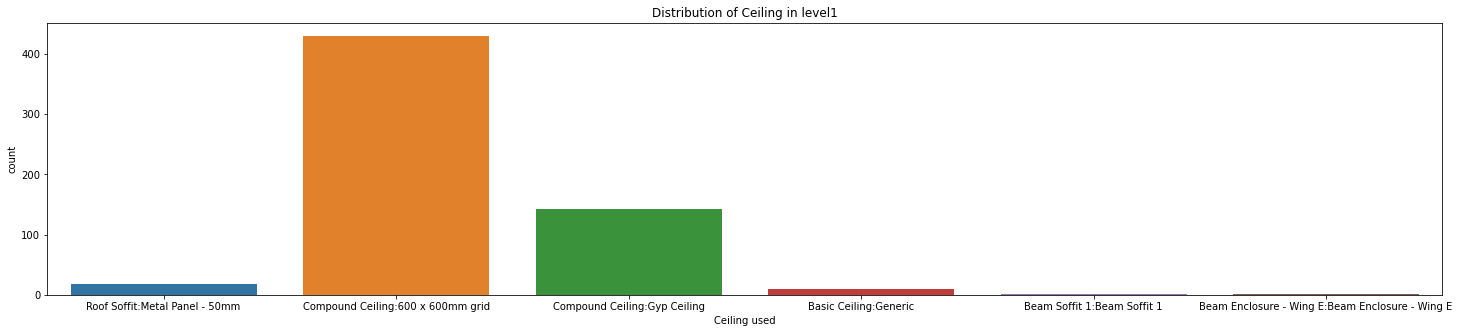

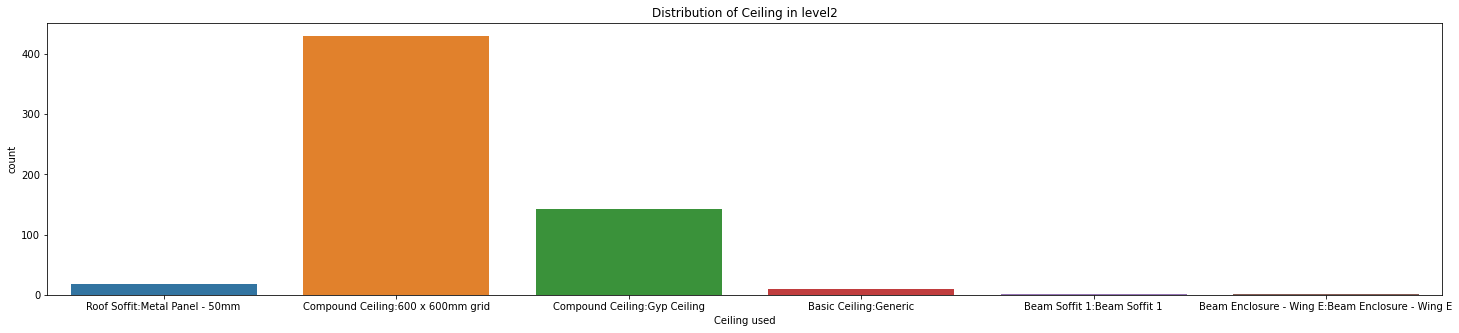

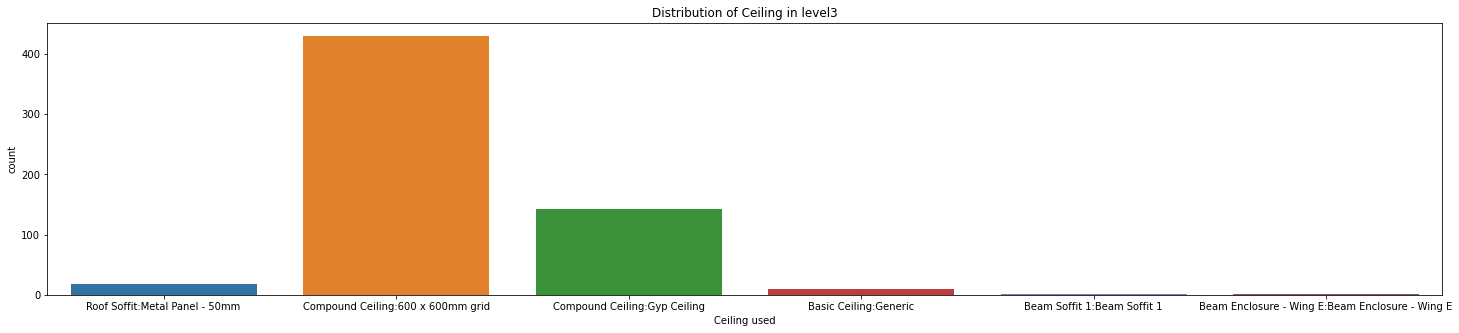

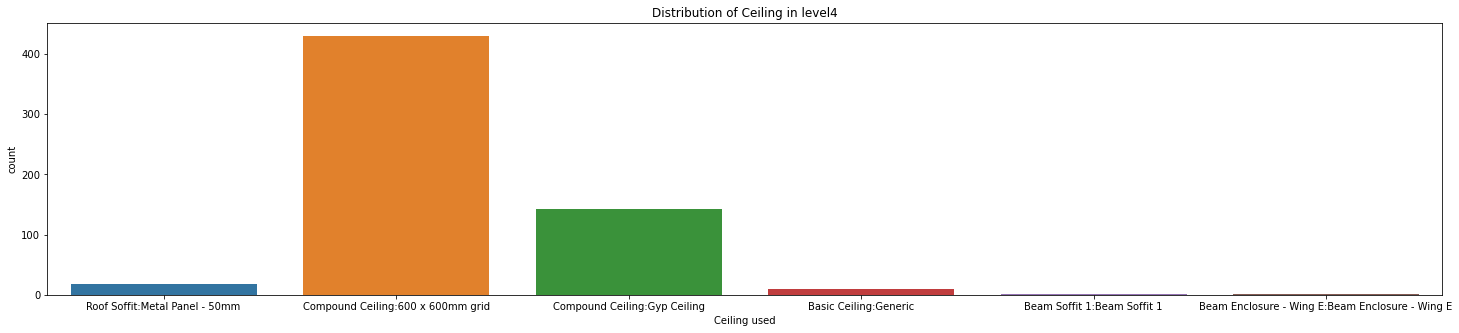

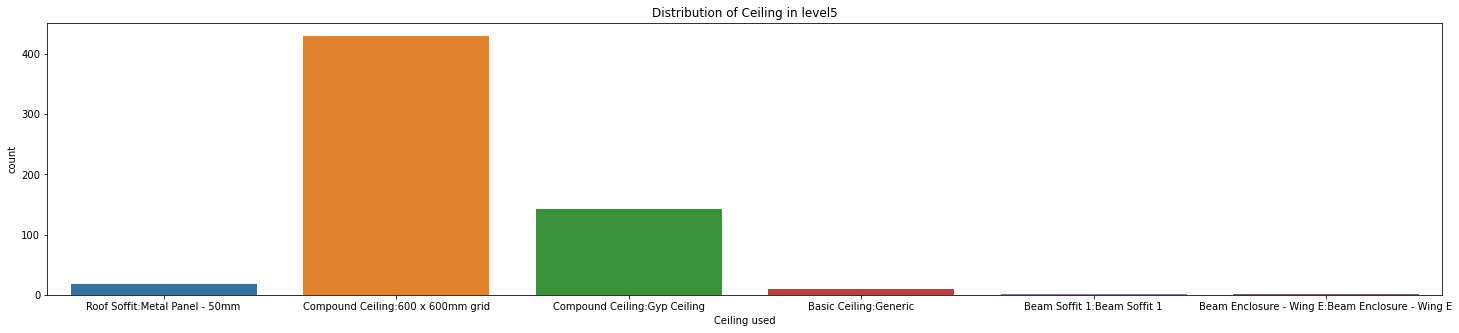

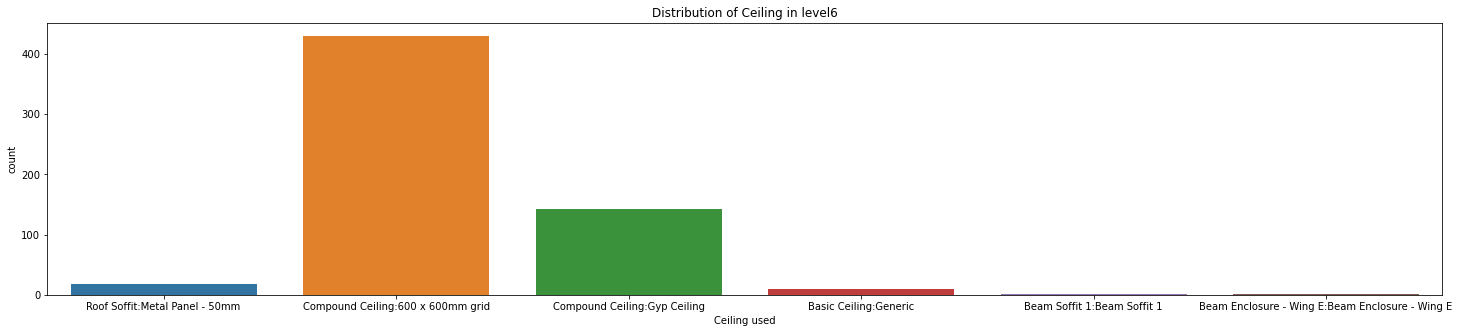

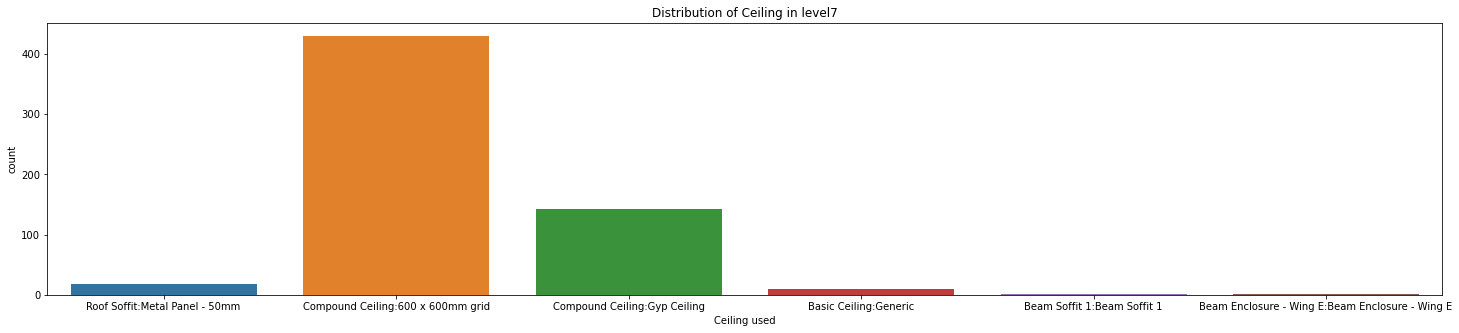

In [92]:
mat=['Roof Soffit:Metal Panel - 50mm',
       'Compound Ceiling:600 x 600mm grid',
       'Compound Ceiling:Gyp Ceiling', 'Basic Ceiling:Generic',
       'Beam Soffit 1:Beam Soffit 1',
       'Beam Enclosure - Wing E:Beam Enclosure - Wing E']
for i in range(1,8):
        wall_level1=be[be["Level"]==i]
        display(be['Pset_CoveringCommon.Reference'].value_counts().sort_values(ascending=False))
        plt.figure(figsize=[25, 5])

        base_color = sns.color_palette()[0]
        sns.countplot(data = be, x = 'Pset_CoveringCommon.Reference', order=mat)
        plt.title('Distribution of Ceiling in level'+str(i))
        plt.xlabel('Ceiling used') 

In [97]:
mat=['Roof Soffit:Metal Panel - 50mm',
       'Compound Ceiling:600 x 600mm grid',
       'Compound Ceiling:Gyp Ceiling', 'Basic Ceiling:Generic',
       'Beam Soffit 1:Beam Soffit 1',
       'Beam Enclosure - Wing E:Beam Enclosure - Wing E']
for ele in mat:
        wall_level1=be[be["Pset_CoveringCommon.Reference"]==ele]
        display(be['BaseQuantities.GrossCeilingArea'].sum())

16826.479631009694

16826.479631009694

16826.479631009694

16826.479631009694

16826.479631009694

16826.479631009694